In [284]:
#Notebook's settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#from jupyterthemes import jtplot
#jtplot.reset()

# Plotting

import sys
Folder='/Users/egordanilov/Desktop/Science/Jax_strong_lensing/jax-strong-lensing/'
sys.path.append(Folder)

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
#%matplotlib inline


# Basic imports
import numpy as np
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
import math

#JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

#Optimizer
from jax.scipy.optimize import minimize as jax_minimize
from scipy.optimize import minimize as scipy_minimize

#Jaxtronomy
from jaxtronomy.Coordinates.pixel_grid import PixelGrid
from jaxtronomy.Instrument.psf import PSF
from jaxtronomy.Instrument.noise import Noise
from jaxtronomy.LightModel.light_model import LightModel
from jaxtronomy.LensModel.lens_model import LensModel
from jaxtronomy.LensImage.lens_image import LensImage
from jaxtronomy.Parameters.parameters import Parameters



#Jaxified GRF generator
from jaxtronomy.GaussianRandomField.PowerBox_jaxified import get_jaxified_GRF
import jaxtronomy.GaussianRandomField.PowerBox_jaxified as PowerBox_jax

#Utils for GRF fitting
from jaxtronomy.GaussianRandomField.GRF_fitting import get_parameters,get_lens_models,simulate_perturbed_image,simulate_smooth_image,model_loss_function
#Utils for computing axially averaged spectrum
from jaxtronomy.GaussianRandomField.GRF_fitting import Radial_profile,compute_radial_spectrum
#Utils for fitting the GRF
from jaxtronomy.GaussianRandomField.GRF_fitting import GRF_Loss_perfect_case,GRF_Loss_phase_averaging,GRF_Loss_image_fitting,Spectra_Loss_MSE,Spectra_Loss_MAE

#Utils for handling jax
from jaxtronomy.GaussianRandomField.Jax_Utils import purify_function,jax_map,gradient_descent



# Universal font size
FS = 18

# Theory

Assume that we have GRF perturbed strong lensing event. First, we want to model it without GRF perturbations and consider the residuals.

## Data

simulation: $\psi(\vec{p}_{0})+\delta \psi(A_{0},\beta_{0},\phi_{0})$  
model 1: $\psi(\vec{p_0})$  
$res_{0}=Im(\delta \psi(A_{0},\beta_{0},\phi_{0})+\psi(\vec{p}_{0})-\psi(\vec{p_1}))$

,where $\vec{p}$ is a set of source light and unperturbed lens mass parameters and $A_{0},\beta_{0},\phi_{0}$ are correpsondingly amplitude,power slope and phase realisation of GRF power spectrum. Index 0 would refer to true values or zeroth aproximation.

## Model

mock: $\psi(\vec{p}_{0})+\delta \psi(A^{i},\beta^{j},\phi_{0})$  
model 2: $\psi(\vec{p_0})$  
$res^{i,j}=Im(\delta \psi(A^{i},\beta^{j},\phi^{m})+\psi(\vec{p}_{1})-\psi(\vec{p_2}))$

,where we assume that we know the exact lens-source parameters \vec{p_0}, and exact GRF phase \phi_{0}

## Loss
$ PS\{ res_{0} \}=|FFT\{res_{0}*mask\_ring\}|^{2} $  
$\mathcal{L}^{ij}=|| \ PS\{res_{0}\} - PS\{res^{i,j}\} \ ||$

## Pipeline

Given lens args $\vec{p}_{0}$ and GRF's phase $\phi_{0}$,

simulate data

logA,beta -> GRF potential -> perturbed image -> residuals with unperturbed image -> power spectrum of residuals


# Lensing setup

In [163]:
#GRF true parameters
GRF_LogAmp=-7.
GRF_beta=2.
GRF_seed=1

GRF_params=[GRF_LogAmp,GRF_beta]

## Data grids

In [164]:
npix = 100
pix_scl = 0.08  # arcsec / pixel
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2
transform_pix2angle = pix_scl * np.eye(2)
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates
x_coords = xgrid[0, :]
y_coords = ygrid[:, 0]

## Models

In [165]:
#Source light
source_light_model_list = ['SERSIC_ELLIPSE']
source_light_model = LightModel(source_light_model_list)
kwargs_source_light = [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'center_x': 0.4, 'center_y': 0.15,'e1':0.07,'e2':-0.1}]

#Lens mass
lens_mass_model_list = ['SIE', 'SHEAR','PIXELATED']
lens_mass_model = LensModel(lens_mass_model_list)
GRF_realisation=get_jaxified_GRF([GRF_LogAmp,GRF_beta],GRF_seed,npix,pix_scl)
kwargs_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},\
                    {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0},\
                    {'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': GRF_realisation}]

#Lens light
lens_light_model_list = []
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{}]

## Source light model

In [166]:
source_light_model_list = ['SERSIC_ELLIPSE']
source_light_model = LightModel(source_light_model_list)
kwargs_source_light = [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'center_x': 0.4, 'center_y': 0.15,'e1':0.07,'e2':-0.1}]

## Lens model (SIE + external shear)

In [167]:
# Lens mass
lens_mass_model_list = ['SIE', 'SHEAR','PIXELATED']
lens_mass_model = LensModel(lens_mass_model_list)

GRF_realisation=get_jaxified_GRF([GRF_LogAmp,GRF_beta],GRF_seed,npix,pix_scl)
kwargs_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},\
                    {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0},\
                    {'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': GRF_realisation}]

# Lens light
lens_light_model_list = []
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{}]

#Combined kwargs smooth
kwargs_data = {'kwargs_lens': kwargs_lens_mass[:-1], 'kwargs_source': kwargs_source_light,'kwargs_lens_light':kwargs_lens_light}

#Observation conditions and noise
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.3}
psf = PSF(**kwargs_psf)
kwargs_numerics = {'supersampling_factor': 1}

kwargs_noise={'background_rms': np.zeros((npix, npix)), 'exposure_time': np.inf}

parameters=get_parameters(kwargs_data,lens_mass_model_list,source_light_model_list)

#Noiseless models
perturbed_lens_image,smooth_lens_image=get_lens_models(pixel_grid,psf,kwargs_noise,\
                                                       lens_mass_model_list,source_light_model,lens_light_model,kwargs_numerics)

perturbed_image=simulate_perturbed_image(GRF_realisation,kwargs_data,perturbed_lens_image,x_coords,y_coords)
unperturbed_image=simulate_smooth_image(kwargs_data,smooth_lens_image)

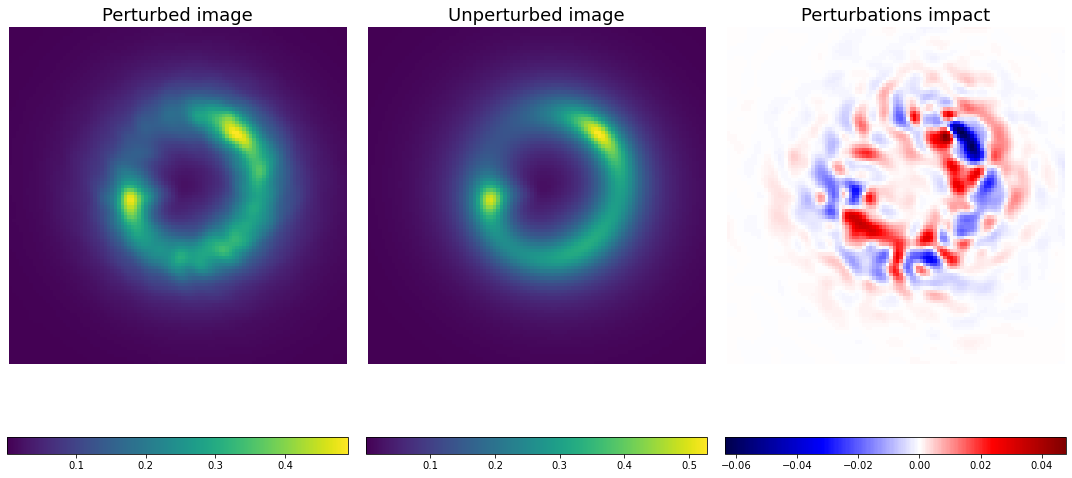

In [168]:
# Plot
fig, ax = plt.subplots(1, 3, figsize=(15, 7))

im0=ax[0].imshow(perturbed_image, origin='lower')
ax[0].set_title("Perturbed image", fontsize=FS)


im1=ax[1].imshow(unperturbed_image, origin='lower')
ax[1].set_title("Unperturbed image", fontsize=FS)


resid_true=perturbed_image-unperturbed_image
im2=ax[2].imshow(resid_true, origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
ax[2].set_title("Perturbations impact", fontsize=FS)

for i,img in enumerate([im0,im1, im2]):
    ax[i].axis('off')
    fig.colorbar(img, ax=ax[i],orientation='horizontal')

fig.tight_layout()

## Einstein ring Mask

In [169]:
rmin = 0.5
rmax = 3
radius = np.hypot(xgrid, ygrid)
#Mask covering Einstein ring
mask = ((radius >= rmin) & (radius <= rmax)).astype(bool)

#There is no sense to consider Fourier space frequncies referring to sizes 
#That are bigger than the thickness of the masked region
k_vector=np.fft.fftshift(np.fft.fftfreq(npix,pix_scl))[npix//2:]
#Index from which to consider frequencies
mask_spectral_cut_index=np.where(k_vector>1/(rmax-rmin))[0][0]
masked_k_vector=k_vector[mask_spectral_cut_index:]

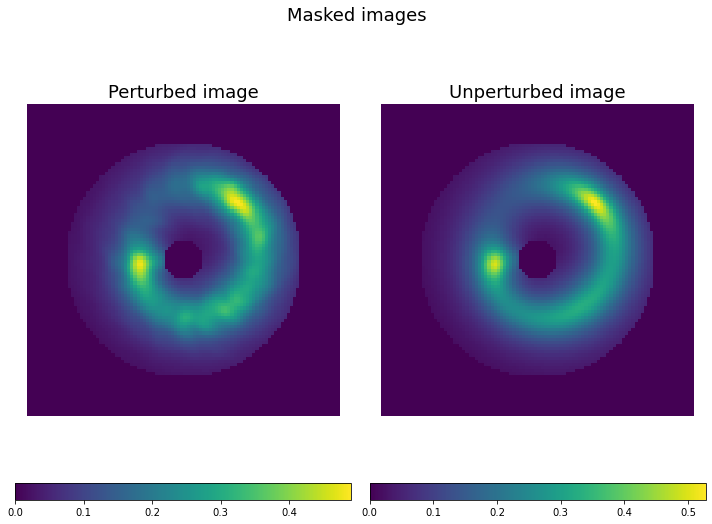

In [170]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 7))
img1 = ax1.imshow(perturbed_image*mask, origin='lower')
ax1.set_title("Perturbed image", fontsize=FS)
img2 = ax2.imshow(unperturbed_image*mask, origin='lower')
ax2.set_title("Unperturbed image", fontsize=FS)
for img, ax in zip((img1, img2), (ax1, ax2)):
    fig.colorbar(img, ax=ax,orientation='horizontal')
    ax.axis('off')
fig.suptitle('Masked images',y=1.1,fontsize=FS)
fig.tight_layout()

## Precompile utility functions

In [171]:
# Precompile the functions with all the arguments that are static for the lensing setup
# So the pure functions depend only on the argument that should be traced

#Generate GRF
def get_jaxified_GRF_pure(GRF_params,GRF_seed):
  return get_jaxified_GRF(GRF_params,GRF_seed,npix,pix_scl)

#Simulate images for kwargs or GRF
simulate_perturbed_image_pure=purify_function(simulate_perturbed_image,kwargs_data,perturbed_lens_image,x_coords,y_coords)
simulate_smooth_image_pure=purify_function(simulate_smooth_image,smooth_lens_image)

#Get axially averaged spectrum
Radial_profile_pure=purify_function(Radial_profile,(npix,npix))
compute_radial_spectrum_pure=purify_function(compute_radial_spectrum,Radial_profile,mask,mask_spectral_cut_index)

# Target spectrum, Initial guess

In [172]:
#Compute Target Power spectrum of data residuals 
resid_true=perturbed_image-unperturbed_image
resid_true_spectrum=compute_radial_spectrum_pure(resid_true)

In [173]:
#First assumption is that power spectrum of GRF is close to power spectrum of residuals
#So fit the target power spectrum with a powerlaw to get an initial guess

def Powerlaw_spectrum(params,masked_k_vector):
  logA,Beta=params
  return np.power(10,logA)*np.power(masked_k_vector,-Beta)

def GRF_PS_loss(params,masked_k_vector,Target_spectrum):
  logA,Beta=params
  GRF_spectrum=Powerlaw_spectrum(params,masked_k_vector)
  MSE= np.power((Target_spectrum-GRF_spectrum)/Target_spectrum,2)
  return np.mean(MSE)

#Make a fit
res=scipy_minimize(GRF_PS_loss,x0=[0.,1.],args=(masked_k_vector,resid_true_spectrum))
GRF_init_guess=np.array(res.x)

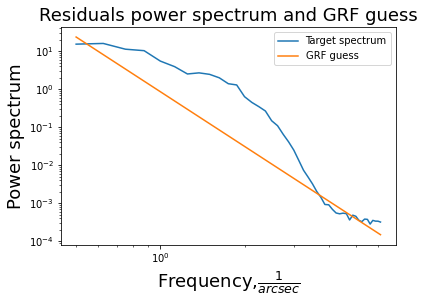

In [174]:
#Plot power spectrum and initial guess
plt.loglog(masked_k_vector,resid_true_spectrum,label='Target spectrum')
plt.loglog(masked_k_vector,Powerlaw_spectrum(GRF_init_guess,masked_k_vector),label='GRF guess')
plt.xlabel('Frequency,' r'$\frac{1}{arcsec}$',fontsize=FS)
plt.ylabel('Power spectrum',fontsize=FS)
plt.title('Residuals power spectrum and GRF guess',fontsize=FS)
plt.legend()
plt.show()

In [175]:
def compute_func_on_grid(GRF_Amps_array,GRF_Betas_array,func,output_size):
    res=np.zeros((len(GRF_Amps_array),len(GRF_Betas_array),output_size))

    for i in tqdm(range(100)):
        for j in range(100):
            res[i,j]=func([GRF_Amps_array[i],GRF_Betas_array[j]])
            
    return res

In [176]:
GRF_Amps_array_narrow=np.linspace(-7.05,-6.95,100)
GRF_Betas_array_narrow=np.linspace(1.5,2.5,100)

# GRF perfect case

In [177]:
#Pick spectrum loss type (weighted MSE or weighted MAE)
Spectra_Loss_pure=purify_function(Spectra_Loss_MAE,resid_true_spectrum)
GRF_Loss_args=(GRF_seed,unperturbed_image,get_jaxified_GRF_pure,simulate_perturbed_image_pure,compute_radial_spectrum_pure,Spectra_Loss_pure)

#Precompile GRF_Loss 
GRF_Loss_pure=purify_function(GRF_Loss_perfect_case,*GRF_Loss_args)

In [153]:
'''GRF_perf_losses_grid_narrow=compute_func_on_grid(GRF_Amps_array_narrow,GRF_Betas_array_narrow,GRF_Loss_pure,1)
GRF_perf_gradlosses_grid_narrow=compute_func_on_grid(GRF_Amps_array_narrow,GRF_Betas_array_narrow,jax.grad(GRF_Loss_pure),2)

#np.save(Folder+'Data/Perfect_case/Narrow_Loss_grid/GRF_perf_losses_grid_narrow.npy',GRF_perf_losses_grid_narrow)
#np.save(Folder+'Data/Perfect_case/Narrow_Loss_grid/GRF_perf_gradlosses_grid_narrow.npy',GRF_perf_gradlosses_grid_narrow)'''

100%|█████████████████████████████████████████| 100/100 [00:30<00:00,  3.23it/s]


In [193]:
GRF_perf_losses_grid_narrow=np.load(Folder+'Data/Perfect_case/Narrow_Loss_grid/GRF_perf_losses_grid_narrow.npy',allow_pickle=True)
GRF_perf_gradlosses_grid_narrow=np.load(Folder+'Data/Perfect_case/Narrow_Loss_grid/GRF_perf_gradlosses_grid_narrow.npy',allow_pickle=True)

/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_21163/1461396177.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ticks = np.linspace(0, 100 - 1, num_ticks, dtype=np.int)


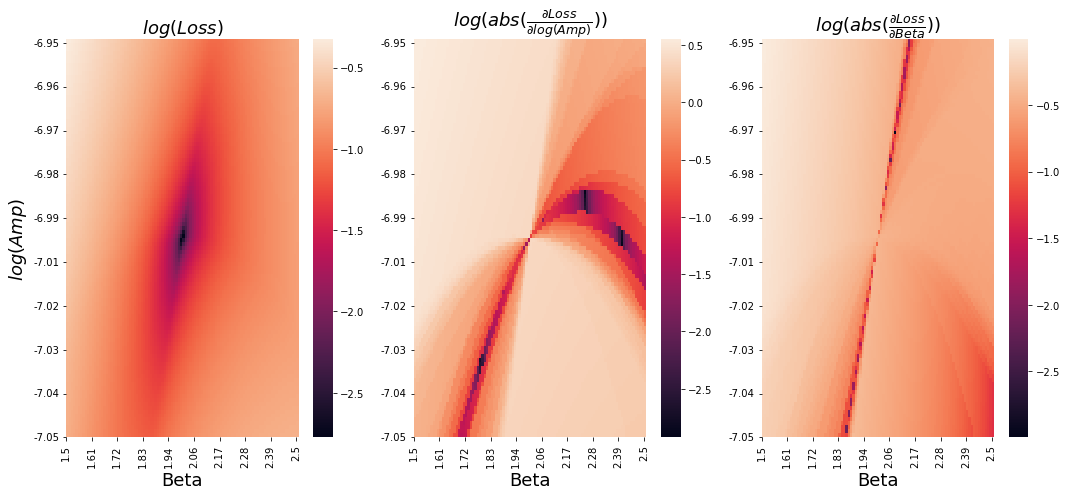

In [194]:
A_array=GRF_Amps_array_narrow
Beta_array=GRF_Betas_array_narrow

loss_grid=GRF_perf_losses_grid_narrow[:,:,0]
gradA_grid=GRF_perf_gradlosses_grid_narrow[:,:,0]
gradBeta_grid=GRF_perf_gradlosses_grid_narrow[:,:,1]

fig,ax=plt.subplots(1,3,figsize=(15,7))

y_labels=np.round(A_array,9)
x_labels=np.round(Beta_array,2)

num_ticks = 10
# the index of the position of yticks
ticks = np.linspace(0, 100 - 1, num_ticks, dtype=np.int)
# the content of labels of these yticks
xticklabels = np.round([x_labels[idx] for idx in ticks],2)
yticklabels = np.round([y_labels[idx] for idx in ticks],2)

def set_labels(im):
    im.set_yticks(ticks)
    im.set_yticklabels(yticklabels)
    im.set_xticks(ticks)
    im.set_xticklabels(xticklabels)
    

im=sns.heatmap(ax=ax[0],data=np.log10(loss_grid),xticklabels=x_labels,yticklabels=yticklabels)
set_labels(im)

im=sns.heatmap(ax=ax[1],data=np.log10(np.abs(gradA_grid)),xticklabels=xticklabels,yticklabels=yticklabels)
set_labels(im)

im=sns.heatmap(ax=ax[2],data=np.log10(np.abs(gradBeta_grid)),xticklabels=xticklabels,yticklabels=yticklabels)
set_labels(im)

#ax[1].set_yticks([])
#ax[2].set_yticks([])

fig_names=[r'$log(Loss)$',r'$log(abs(\frac{\partial Loss}{\partial log(Amp)}))$',r'$log(abs(\frac{\partial Loss}{\partial Beta}))$']
for i in range(3):
  ax[i].set_title(fig_names[i],fontsize=FS)
  ax[i].set_xlabel('Beta',fontsize=FS)
  ax[i].invert_yaxis()

ax[0].set_ylabel(r'$log(Amp)$',fontsize=FS)
fig.tight_layout()

plt.show()

# GRF unknown phase fitting

## MAE loss

In [236]:
#Pick spectrum loss type (weighted MSE or weighted MAE)
Spectra_Loss_pure=purify_function(Spectra_Loss_MAE,resid_true_spectrum)

Seeds_number=10
#Seeds that do not contain the true one
GRF_seeds=np.arange(GRF_seed+1,GRF_seed+11)

GRF_Loss_args=(GRF_seeds,unperturbed_image,get_jaxified_GRF_pure,simulate_perturbed_image_pure,compute_radial_spectrum_pure,Spectra_Loss_pure)

#Precompile GRF_Loss 
GRF_Loss_pure=purify_function(GRF_Loss_phase_averaging,*GRF_Loss_args)

In [198]:
'''GRF_phase_losses_grid_narrow=compute_func_on_grid(GRF_Amps_array_narrow,GRF_Betas_array_narrow,GRF_Loss_pure,1)
GRF_phase_gradlosses_grid_narrow=compute_func_on_grid(GRF_Amps_array_narrow,GRF_Betas_array_narrow,jax.grad(GRF_Loss_pure),2)

#np.save(Folder+'Data/Phase_averaging/MAE/Narrow_Loss_grid/GRF_phase_losses_grid_narrow.npy',GRF_phase_losses_grid_narrow)
#np.save(Folder+'Data/Phase_averaging/MAE/Narrow_Loss_grid/GRF_phase_gradlosses_grid_narrow.npy',GRF_phase_gradlosses_grid_narrow)'''

In [199]:
GRF_phase_losses_grid_narrow=np.load(Folder+'Data/Phase_averaging/MAE/Narrow_Loss_grid/GRF_phase_losses_grid_narrow.npy',allow_pickle=True)
GRF_phase_gradlosses_grid_narrow=np.load(Folder+'Data/Phase_averaging/MAE/Narrow_Loss_grid/GRF_phase_gradlosses_grid_narrow.npy',allow_pickle=True)

/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_21163/1430954129.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ticks = np.linspace(0, 100 - 1, num_ticks, dtype=np.int)


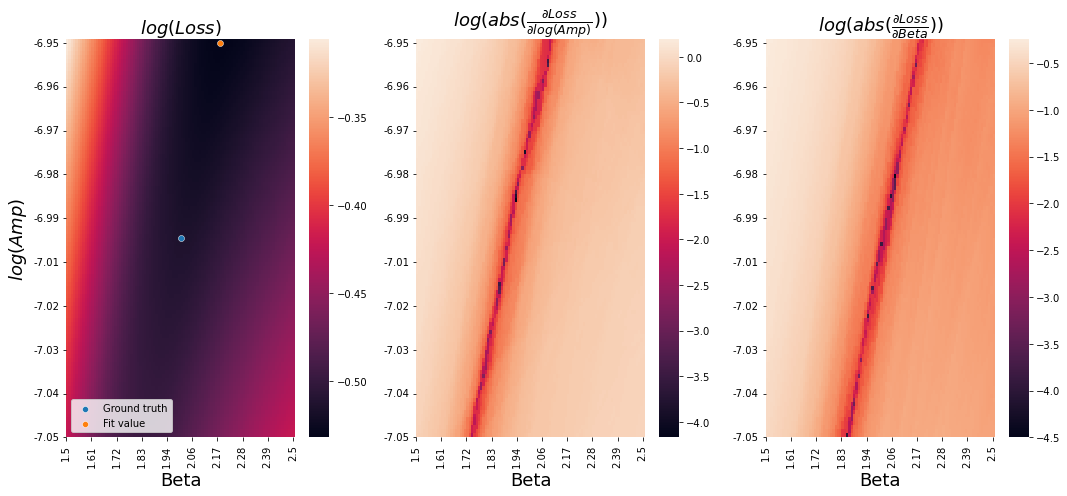

In [209]:
A_array=GRF_Amps_array_narrow
Beta_array=GRF_Betas_array_narrow

loss_grid=GRF_phase_losses_grid_narrow[:,:,0]
gradA_grid=GRF_phase_gradlosses_grid_narrow[:,:,0]
gradBeta_grid=GRF_phase_gradlosses_grid_narrow[:,:,1]

fig,ax=plt.subplots(1,3,figsize=(15,7))

y_labels=np.round(A_array,9)
x_labels=np.round(Beta_array,2)

num_ticks = 10
# the index of the position of yticks
ticks = np.linspace(0, 100 - 1, num_ticks, dtype=np.int)
# the content of labels of these yticks
xticklabels = np.round([x_labels[idx] for idx in ticks],2)
yticklabels = np.round([y_labels[idx] for idx in ticks],2)

def set_labels(im):
    im.set_yticks(ticks)
    im.set_yticklabels(yticklabels)
    im.set_xticks(ticks)
    im.set_xticklabels(xticklabels)
    

min_i,min_j=np.where(loss_grid==loss_grid.min())
im=sns.heatmap(ax=ax[0],data=np.log10(loss_grid),xticklabels=x_labels,yticklabels=yticklabels)
sns.scatterplot(ax=ax[0],x=[50],y=[50],label='Ground truth')
sns.scatterplot(ax=ax[0],x=[min_j.item()],y=[min_i.item()],label='Fit value')
ax[0].legend(loc='lower left')

set_labels(im)

im=sns.heatmap(ax=ax[1],data=np.log10(np.abs(gradA_grid)),xticklabels=xticklabels,yticklabels=yticklabels)
set_labels(im)

im=sns.heatmap(ax=ax[2],data=np.log10(np.abs(gradBeta_grid)),xticklabels=xticklabels,yticklabels=yticklabels)
set_labels(im)

#ax[1].set_yticks([])
#ax[2].set_yticks([])

fig_names=[r'$log(Loss)$',r'$log(abs(\frac{\partial Loss}{\partial log(Amp)}))$',r'$log(abs(\frac{\partial Loss}{\partial Beta}))$']
for i in range(3):
  ax[i].set_title(fig_names[i],fontsize=FS)
  ax[i].set_xlabel('Beta',fontsize=FS)
  ax[i].invert_yaxis()

ax[0].set_ylabel(r'$log(Amp)$',fontsize=FS)
fig.tight_layout()

plt.show()

### Optimization

In [211]:
Seeds_number=10
#Seeds that do not contain the true one
GRF_seeds=np.arange(GRF_seed+1,GRF_seed+11)

GRF_Loss_args=(GRF_seeds,unperturbed_image,get_jaxified_GRF_pure,simulate_perturbed_image_pure,compute_radial_spectrum_pure,Spectra_Loss_pure)

#Precompile GRF_Loss 
GRF_Loss_pure=purify_function(GRF_Loss_phase_averaging,*GRF_Loss_args)

loss_func=GRF_Loss_pure
grad_loss_func=jax.grad(GRF_Loss_pure)
hess_loss_func=jax.jacfwd(jax.jacrev(loss_func))

In [218]:
%timeit loss_func(GRF_params)
%timeit grad_loss_func(GRF_params)
%timeit hess_loss_func(GRF_params)

30.3 ms ± 553 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
63.6 ms ± 373 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
172 ms ± 7.59 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [226]:
Nfeval = 0
history=np.zeros((0,2))
init_guess=GRF_init_guess
bounds=((-10., -0.), (1., 10.0))

def callbackF(Xi,optimizer):
    global Nfeval
    global history
    
    loss=loss_func(Xi)
    grad=grad_loss_func(Xi)
    if (len(history)%10==0):
        print('{0:4d}   {1:3.6f}   {2: 3.6f}   {3: 3.6f}   {4: 3.6f} {5: 3.6f}'.format(Nfeval, Xi[0], Xi[1], loss,grad[0],grad[1]))
    
    Nfeval += 1
    history=np.append(history,[Xi],axis=0)


res=scipy_minimize(loss_func,GRF_init_guess,jac=grad_loss_func,hess=hess_loss_func,bounds=bounds,method='trust-constr',options={'disp': True},callback=callbackF)

   0   -0.061505    4.781217    161.598044    0.053863  0.063518
  10   -9.625562    3.522165    0.998078   -0.004428 -0.000767
  20   -8.517890    4.209673    0.961263   -0.089296 -0.035235
  30   -7.569730    4.686293    0.529762   -0.151260 -0.016197
  40   -7.421578    4.536637    0.517500    0.197590  0.205158
  50   -7.296448    4.307605    0.493179    0.147292  0.196562
  60   -7.244785    4.067199    0.465503   -0.250255  0.012146
  70   -7.150294    3.812319    0.436479   -0.367604 -0.020942
  80   -7.078183    3.600902    0.411138   -0.333649  0.010808
  90   -7.021718    3.382663    0.386748   -0.320659  0.044710
 100   -6.982752    3.173130    0.362160   -0.397992  0.059164
 110   -6.954288    2.967863    0.338610   -0.347672  0.070686
 120   -6.943230    2.805623    0.322794   -0.406102  0.070454
 130   -6.935274    2.669748    0.311257   -0.349807  0.055500
 140   -6.930700    2.560015    0.303848   -0.356155  0.046484
 150   -6.884503    2.519049    0.294305    0.114530 

In [ ]:
loss_history=np.array([loss_func(x) for x in tqdm(history)])
grads_history=np.array([grad_loss_func(x) for x in tqdm(history)])

In [237]:
#np.save(Folder+'Data/Phase_averaging/MAE/Narrow_Loss_grid/history_M=10.npy',history)
#np.save(Folder+'Data/Phase_averaging/MAE/Narrow_Loss_grid/loss_history_M=10.npy',loss_history)
#np.save(Folder+'Data/Phase_averaging/MAE/Narrow_Loss_grid/grads_history_M=10.npy',grads_history)
history=np.load(Folder+'Data/Phase_averaging/MAE/Narrow_Loss_grid/history_M=10.npy',allow_pickle=True)
loss_history=np.load(Folder+'Data/Phase_averaging/MAE/Narrow_Loss_grid/loss_history_M=10.npy',allow_pickle=True)
grads_history=np.load(Folder+'Data/Phase_averaging/MAE/Narrow_Loss_grid/grads_history_M=10.npy',allow_pickle=True)

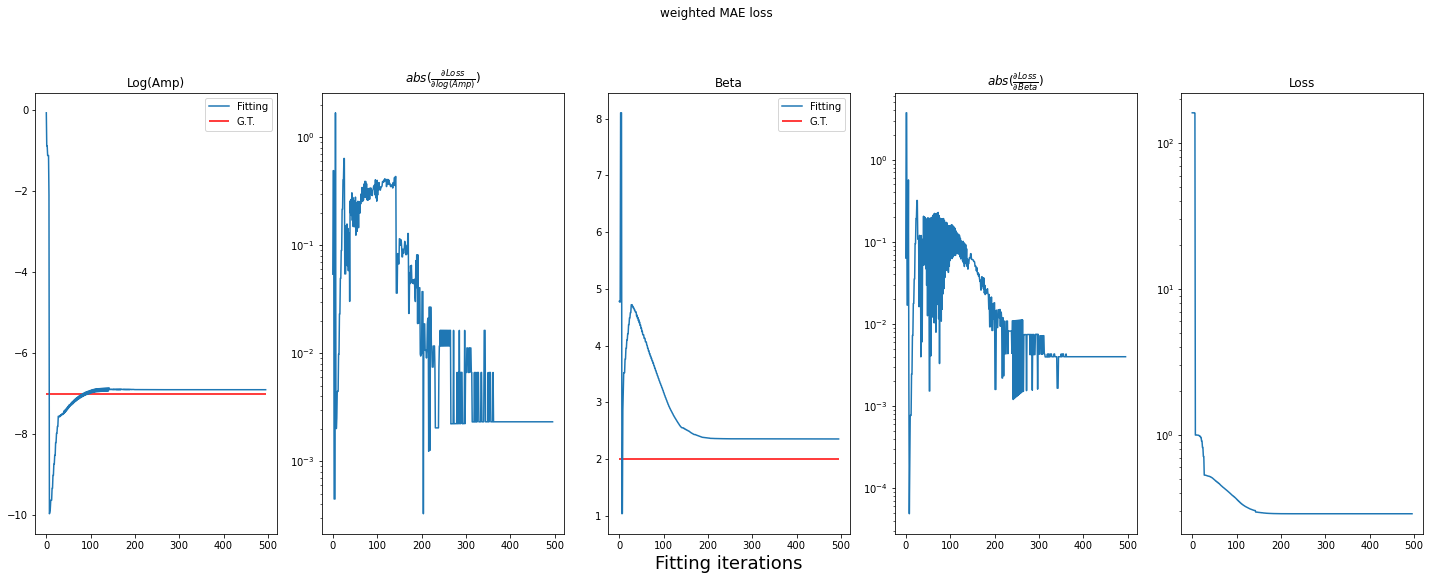

In [238]:
fig,ax=plt.subplots(1,5,figsize=(20,7))

ax[0].plot(history[:,0],label='Fitting')
ax[0].set_title('Log(Amp)')
ax[0].hlines(GRF_LogAmp,0,len(history),color='red',label='G.T.')
#ax[0].hlines(bounds[0][0],0,len(history),color='black',label='Bounds')
#ax[0].hlines(bounds[0][1],0,len(history),color='black',label='Bounds')
ax[0].legend()



grads_history=np.array(grads_history)
loss_history=np.array(loss_history)

ax[1].plot(np.abs(grads_history[:,0]))
ax[1].set_yscale('log')
ax[1].set_title(r'$abs(\frac{\partial Loss}{\partial log(Amp)})$')


ax[2].plot(history[:,1],label='Fitting')
ax[2].set_title('Beta')
ax[2].hlines(GRF_beta,0,len(history),color='red',label='G.T.')
ax[2].legend()

ax[3].plot(np.abs(grads_history[:,1]))
ax[3].set_title(r'$abs(\frac{\partial Loss}{\partial Beta})$')
ax[3].set_yscale('log')



ax[4].plot(loss_history)
ax[4].set_yscale('log')
ax[4].set_title('Loss')

fig.tight_layout()
fig.suptitle('weighted MAE loss',y=1.1)



fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Fitting iterations',fontsize=FS)

plt.show()

## MSE loss

In [240]:
#Pick spectrum loss type (weighted MSE or weighted MAE)
Spectra_Loss_pure=purify_function(Spectra_Loss_MSE,resid_true_spectrum)

Seeds_number=10
#Seeds that do not contain the true one
GRF_seeds=np.arange(GRF_seed+1,GRF_seed+11)

GRF_Loss_args=(GRF_seeds,unperturbed_image,get_jaxified_GRF_pure,simulate_perturbed_image_pure,compute_radial_spectrum_pure,Spectra_Loss_pure)

#Precompile GRF_Loss 
GRF_Loss_pure=purify_function(GRF_Loss_phase_averaging,*GRF_Loss_args)

In [241]:
GRF_phase_losses_grid_narrow=compute_func_on_grid(GRF_Amps_array_narrow,GRF_Betas_array_narrow,GRF_Loss_pure,1)
GRF_phase_gradlosses_grid_narrow=compute_func_on_grid(GRF_Amps_array_narrow,GRF_Betas_array_narrow,jax.grad(GRF_Loss_pure),2)

np.save(Folder+'Data/Phase_averaging/MSE/Narrow_Loss_grid/GRF_phase_losses_grid_narrow.npy',GRF_phase_losses_grid_narrow)
np.save(Folder+'Data/Phase_averaging/MSE/Narrow_Loss_grid/GRF_phase_gradlosses_grid_narrow.npy',GRF_phase_gradlosses_grid_narrow)

100%|█████████████████████████████████████████| 100/100 [10:38<00:00,  6.39s/it]


/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_21163/3837505449.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ticks = np.linspace(0, 100 - 1, num_ticks, dtype=np.int)


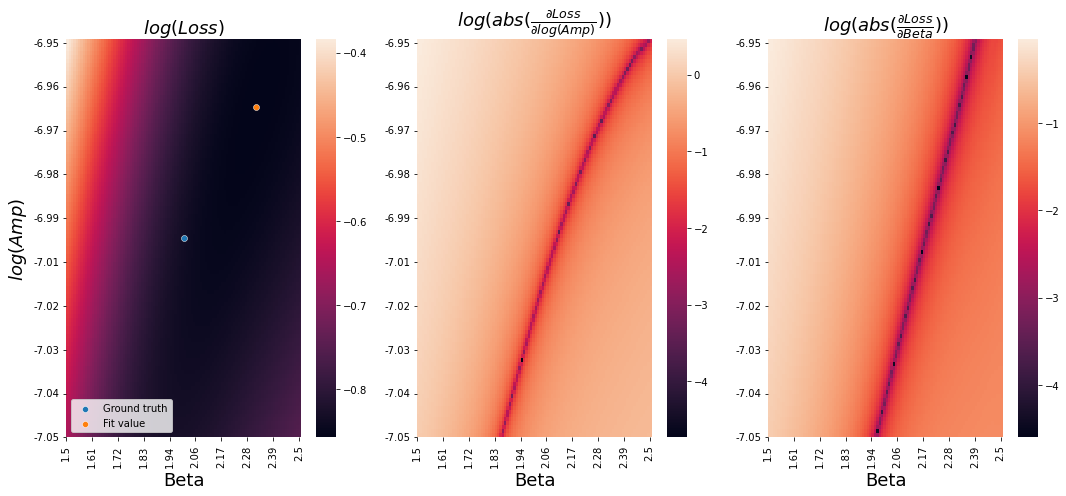

In [242]:
GRF_phase_losses_grid_narrow=np.load(Folder+'Data/Phase_averaging/MSE/Narrow_Loss_grid/GRF_phase_losses_grid_narrow.npy',allow_pickle=True)
GRF_phase_gradlosses_grid_narrow=np.load(Folder+'Data/Phase_averaging/MSE/Narrow_Loss_grid/GRF_phase_gradlosses_grid_narrow.npy',allow_pickle=True)

A_array=GRF_Amps_array_narrow
Beta_array=GRF_Betas_array_narrow

loss_grid=GRF_phase_losses_grid_narrow[:,:,0]
gradA_grid=GRF_phase_gradlosses_grid_narrow[:,:,0]
gradBeta_grid=GRF_phase_gradlosses_grid_narrow[:,:,1]

fig,ax=plt.subplots(1,3,figsize=(15,7))

y_labels=np.round(A_array,9)
x_labels=np.round(Beta_array,2)

num_ticks = 10
# the index of the position of yticks
ticks = np.linspace(0, 100 - 1, num_ticks, dtype=np.int)
# the content of labels of these yticks
xticklabels = np.round([x_labels[idx] for idx in ticks],2)
yticklabels = np.round([y_labels[idx] for idx in ticks],2)

def set_labels(im):
    im.set_yticks(ticks)
    im.set_yticklabels(yticklabels)
    im.set_xticks(ticks)
    im.set_xticklabels(xticklabels)
    

min_i,min_j=np.where(loss_grid==loss_grid.min())
im=sns.heatmap(ax=ax[0],data=np.log10(loss_grid),xticklabels=x_labels,yticklabels=yticklabels)
sns.scatterplot(ax=ax[0],x=[50],y=[50],label='Ground truth')
sns.scatterplot(ax=ax[0],x=[min_j.item()],y=[min_i.item()],label='Fit value')
ax[0].legend(loc='lower left')

set_labels(im)

im=sns.heatmap(ax=ax[1],data=np.log10(np.abs(gradA_grid)),xticklabels=xticklabels,yticklabels=yticklabels)
set_labels(im)

im=sns.heatmap(ax=ax[2],data=np.log10(np.abs(gradBeta_grid)),xticklabels=xticklabels,yticklabels=yticklabels)
set_labels(im)

#ax[1].set_yticks([])
#ax[2].set_yticks([])

fig_names=[r'$log(Loss)$',r'$log(abs(\frac{\partial Loss}{\partial log(Amp)}))$',r'$log(abs(\frac{\partial Loss}{\partial Beta}))$']
for i in range(3):
  ax[i].set_title(fig_names[i],fontsize=FS)
  ax[i].set_xlabel('Beta',fontsize=FS)
  ax[i].invert_yaxis()

ax[0].set_ylabel(r'$log(Amp)$',fontsize=FS)
fig.tight_layout()

plt.show()

### Optimization

In [243]:
Seeds_number=10
#Seeds that do not contain the true one
GRF_seeds=np.arange(GRF_seed+1,GRF_seed+11)

GRF_Loss_args=(GRF_seeds,unperturbed_image,get_jaxified_GRF_pure,simulate_perturbed_image_pure,compute_radial_spectrum_pure,Spectra_Loss_pure)

#Precompile GRF_Loss 
GRF_Loss_pure=purify_function(GRF_Loss_phase_averaging,*GRF_Loss_args)

loss_func=GRF_Loss_pure
grad_loss_func=jax.grad(GRF_Loss_pure)
hess_loss_func=jax.jacfwd(jax.jacrev(loss_func))

In [244]:
%timeit loss_func(GRF_params)
%timeit grad_loss_func(GRF_params)
%timeit hess_loss_func(GRF_params)

30.1 ms ± 328 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
63.3 ms ± 1.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
174 ms ± 2.18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [245]:
Nfeval = 0
history=np.zeros((0,2))
init_guess=GRF_init_guess
bounds=((-10., -0.), (1., 10.0))

def callbackF(Xi,optimizer):
    global Nfeval
    global history
    
    loss=loss_func(Xi)
    grad=grad_loss_func(Xi)
    if (len(history)%10==0):
        print('{0:4d}   {1:3.6f}   {2: 3.6f}   {3: 3.6f}   {4: 3.6f} {5: 3.6f}'.format(Nfeval, Xi[0], Xi[1], loss,grad[0],grad[1]))
    
    Nfeval += 1
    history=np.append(history,[Xi],axis=0)


res=scipy_minimize(loss_func,GRF_init_guess,jac=grad_loss_func,hess=hess_loss_func,bounds=bounds,method='trust-constr',options={'disp': True},callback=callbackF)

   0   -0.061505    4.781217    54016.206226    38.291168  39.315550
  10   -0.881709    4.788108    53834.719396    562.327266  6577.087468
  20   -1.229554    4.777030    53723.733649    141.682150 -2735.257700
  30   -1.064569    4.784720    53677.934996   -127.709947  21709.821706
  40   -1.051280    4.783569    53642.145414   -1526.967110  35210.131399
  50   -1.051135    4.783486    53642.106903   -1450.666719 -39492.212341
  60   -1.050506    4.783507    53640.167547    237.155115  923.514926
  70   -3.183343    4.168389    30271.203773    31622.358688  6079.458758
  80   -7.020595    3.905187    0.370007    1.525972  0.720448
  90   -6.954859    2.406676    0.139323    0.012891  0.009572
 100   -6.966216    2.318679    0.138840    0.000001  0.000004
`gtol` termination condition is satisfied.
Number of iterations: 103, function evaluations: 103, CG iterations: 138, optimality: 7.80e-10, constraint violation: 0.00e+00, execution time: 2.5e+01 s.


In [246]:
loss_history=np.array([loss_func(x) for x in tqdm(history)])
grads_history=np.array([grad_loss_func(x) for x in tqdm(history)])

100%|█████████████████████████████████████████| 103/103 [00:07<00:00, 14.60it/s]


In [247]:
np.save(Folder+'Data/Phase_averaging/MSE/Narrow_Loss_grid/history_M=10.npy',history)
np.save(Folder+'Data/Phase_averaging/MSE/Narrow_Loss_grid/loss_history_M=10.npy',loss_history)
np.save(Folder+'Data/Phase_averaging/MSE/Narrow_Loss_grid/grads_history_M=10.npy',grads_history)
history=np.load(Folder+'Data/Phase_averaging/MSE/Narrow_Loss_grid/history_M=10.npy',allow_pickle=True)
loss_history=np.load(Folder+'Data/Phase_averaging/MSE/Narrow_Loss_grid/loss_history_M=10.npy',allow_pickle=True)
grads_history=np.load(Folder+'Data/Phase_averaging/MSE/Narrow_Loss_grid/grads_history_M=10.npy',allow_pickle=True)

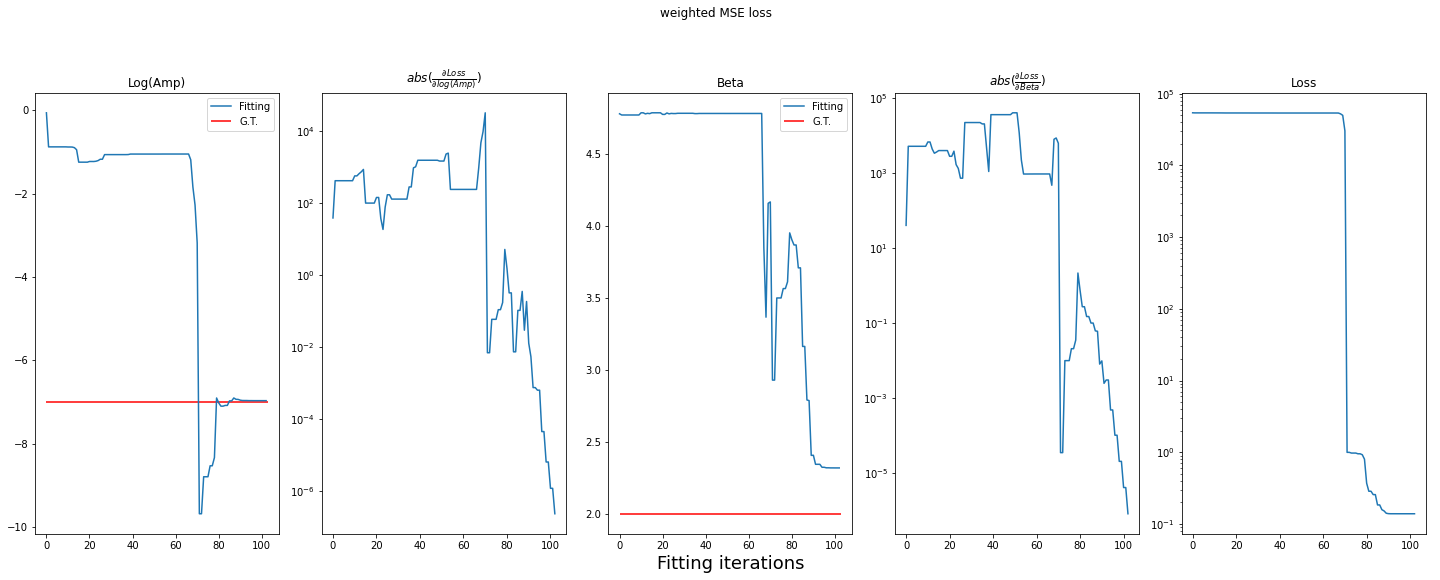

In [249]:
fig,ax=plt.subplots(1,5,figsize=(20,7))

ax[0].plot(history[:,0],label='Fitting')
ax[0].set_title('Log(Amp)')
ax[0].hlines(GRF_LogAmp,0,len(history),color='red',label='G.T.')
#ax[0].hlines(bounds[0][0],0,len(history),color='black',label='Bounds')
#ax[0].hlines(bounds[0][1],0,len(history),color='black',label='Bounds')
ax[0].legend()



grads_history=np.array(grads_history)
loss_history=np.array(loss_history)

ax[1].plot(np.abs(grads_history[:,0]))
ax[1].set_yscale('log')
ax[1].set_title(r'$abs(\frac{\partial Loss}{\partial log(Amp)})$')


ax[2].plot(history[:,1],label='Fitting')
ax[2].set_title('Beta')
ax[2].hlines(GRF_beta,0,len(history),color='red',label='G.T.')
ax[2].legend()

ax[3].plot(np.abs(grads_history[:,1]))
ax[3].set_title(r'$abs(\frac{\partial Loss}{\partial Beta})$')
ax[3].set_yscale('log')



ax[4].plot(loss_history)
ax[4].set_yscale('log')
ax[4].set_title('Loss')

fig.tight_layout()
fig.suptitle('weighted MSE loss',y=1.1)



fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Fitting iterations',fontsize=FS)

plt.show()

### Phase number picking

# GRF unknown args fitting

## Lens fitting max_iter and lr 

(-0.5, 99.5, 99.5, -0.5)

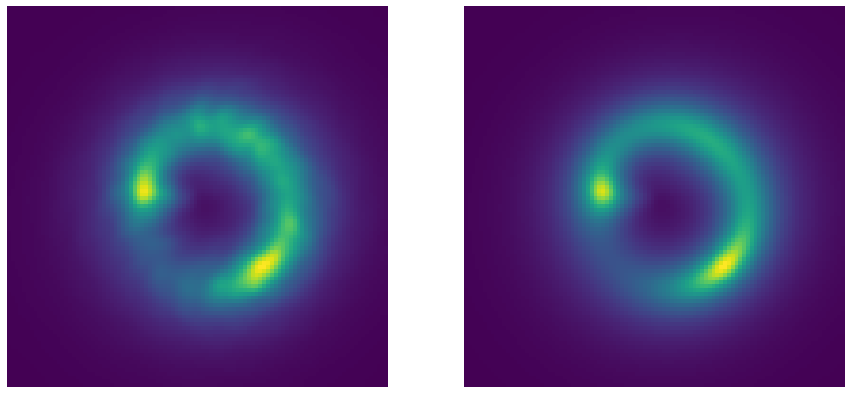

In [37]:
fig,ax=plt.subplots(1,2,figsize=(15,7))

ax[0].imshow(perturbed_image)
ax[0].axis('off')

ax[1].imshow(unperturbed_image)
ax[1].axis('off')

In [263]:
args_data=parameters.kwargs2args(kwargs_data)

def impure_gradient_descent(gradient_function,initial_guess,max_iter,learning_rate):
    history=np.zeros((max_iter,len(initial_guess)))
    history[0]=initial_guess
    
    step_function= lambda X: X-learning_rate*gradient_function(X)
    
    for i in range(1,max_iter):
        history[i]=step_function(history[i-1])
        
    return history

In [90]:
model_loss_function_pure=purify_function(model_loss_function,perturbed_image,parameters,simulate_smooth_image_pure)
model_loss_grad=jax.grad(model_loss_function_pure)

In [104]:
max_iter=500
learning_rate=5e-4

In [107]:
fit_history_3=impure_gradient_descent(model_loss_grad,args_data,max_iter,1e-3)
fit_history_54=impure_gradient_descent(model_loss_grad,args_data,max_iter,5e-4)
fit_history_4=impure_gradient_descent(model_loss_grad,args_data,max_iter,1e-4)

In [108]:
loss_history_3=np.array([model_loss_function_pure(x) for x in fit_history_3])
loss_history_54=np.array([model_loss_function_pure(x) for x in fit_history_54])
loss_history_4=np.array([model_loss_function_pure(x) for x in fit_history_4])

In [112]:
image_fit_3=simulate_smooth_image_pure(parameters.args2kwargs(fit_history_3[-1]))
image_fit_54=simulate_smooth_image_pure(parameters.args2kwargs(fit_history_54[-1]))
image_fit_4=simulate_smooth_image_pure(parameters.args2kwargs(fit_history_4[-1]))

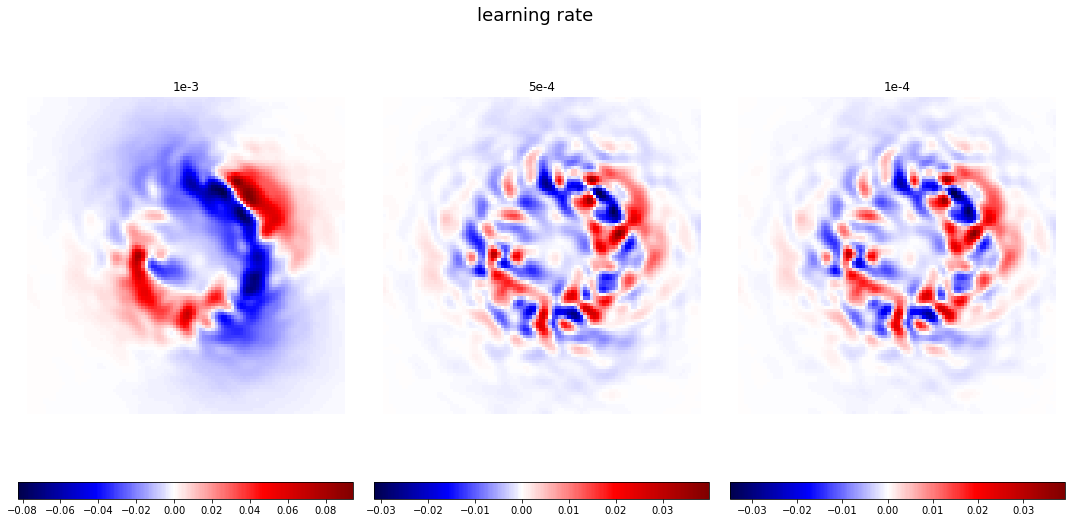

In [119]:
fig,ax=plt.subplots(1,3,figsize=(15,7))

im0=ax[0].imshow(perturbed_image-image_fit_3,origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
ax[0].axis('off')
ax[0].set_title('1e-3')

im1=ax[1].imshow(perturbed_image-image_fit_54,origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
ax[1].axis('off')
ax[1].set_title('5e-4')

im2=ax[2].imshow(perturbed_image-image_fit_4,origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
ax[2].axis('off')
ax[2].set_title('1e-4')

fig.suptitle('learning rate',y=1.1,fontsize=FS)

for i,img in enumerate([im0,im1, im2]):
    ax[i].axis('off')
    fig.colorbar(img, ax=ax[i],orientation='horizontal')

fig.tight_layout()

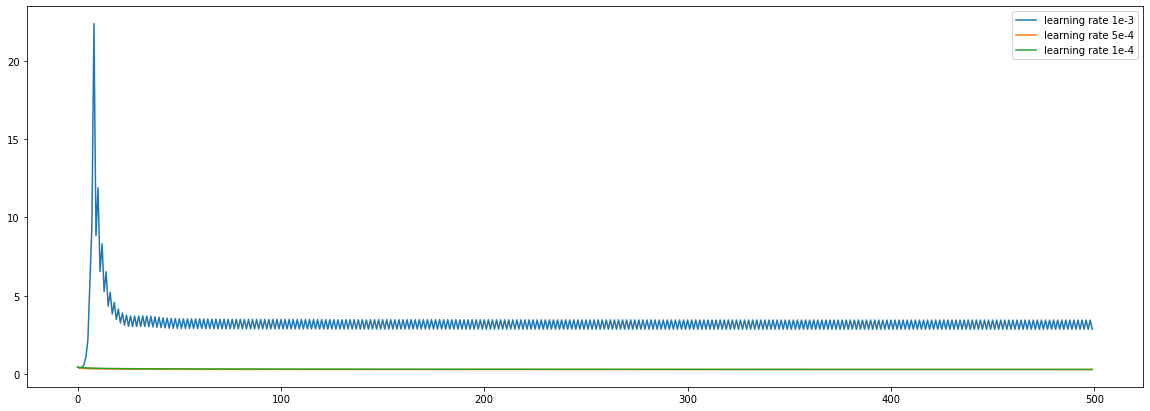

In [120]:
plt.figure(figsize=(20,7))
plt.plot(loss_history_3,label='learning rate 1e-3')
plt.plot(loss_history_54,label='learning rate 5e-4')
plt.plot(loss_history_4,label='learning rate 1e-4')
plt.legend()

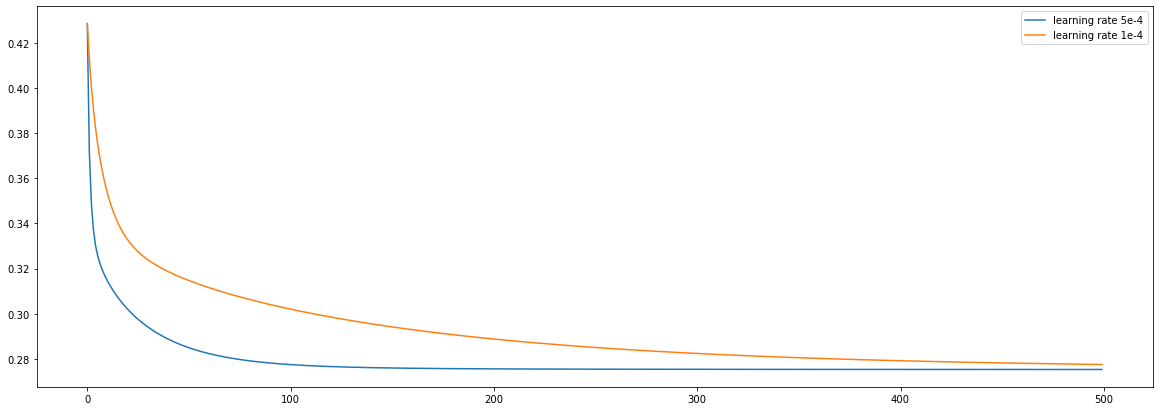

In [125]:
plt.figure(figsize=(20,7))
plt.plot(loss_history_54,label='learning rate 5e-4')
plt.plot(loss_history_4,label='learning rate 1e-4')
plt.legend()

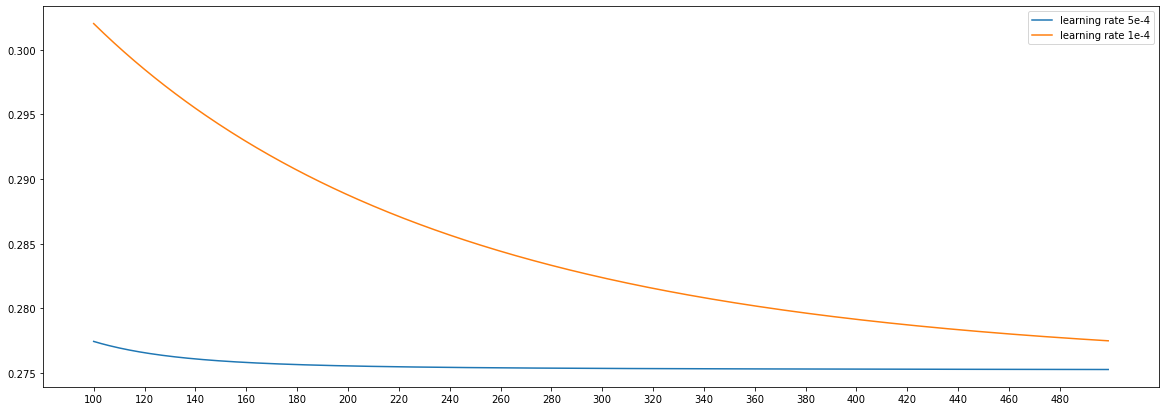

In [137]:
plt.figure(figsize=(20,7))
plt.plot(loss_history_54[100:],label='learning rate 5e-4')
plt.plot(loss_history_4[100:],label='learning rate 1e-4')
ticks=np.arange(len(loss_history_54))
plt.xticks(ticks=ticks[:-100][::20],labels=ticks[100:][::20])
plt.legend()

In [306]:
#These fitting params should be enough
learning_rate=5e-4
max_iter=200

## Fitting observational data

In [302]:
model_loss_function_pure=purify_function(model_loss_function,perturbed_image,parameters,simulate_smooth_image_pure)
model_loss_grad=jax.grad(model_loss_function_pure)
#It's a cheat to start fitting from apriori unknown args_data, but I'll figure the initialising strategy out eventually
args_guess=gradient_descent(model_loss_grad,args_data,max_iter,learning_rate)

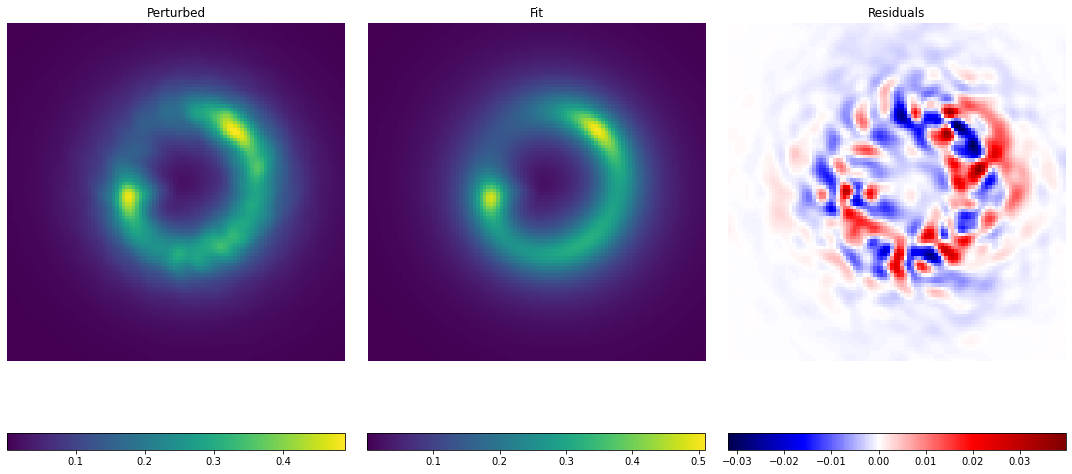

In [303]:
image_fit=simulate_smooth_image_pure(parameters.args2kwargs(args_guess))

fig,ax=plt.subplots(1,3,figsize=(15,7))

im0=ax[0].imshow(perturbed_image,origin='lower')
ax[0].axis('off')
ax[0].set_title('Perturbed')

im1=ax[1].imshow(image_fit,origin='lower')
ax[1].axis('off')
ax[1].set_title('Fit')

im2=ax[2].imshow(perturbed_image-image_fit,origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
ax[2].axis('off')
ax[2].set_title('Residuals')


for i,img in enumerate([im0,im1, im2]):
    ax[i].axis('off')
    fig.colorbar(img, ax=ax[i],orientation='horizontal')

fig.tight_layout()

In [304]:
resid1_spectrum=compute_radial_spectrum_pure(perturbed_image-image_fit)

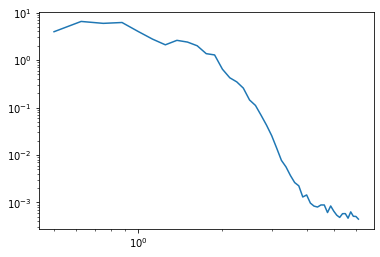

In [305]:
plt.loglog(masked_k_vector,resid1_spectrum)

### MAE GRF Loss

In [313]:
Spectra_Loss_pure=purify_function(Spectra_Loss_MAE,resid1_spectrum)

GRF_Loss_image_fitting_args=(GRF_seed,
                            get_jaxified_GRF_pure,simulate_perturbed_image_pure,\
                            simulate_smooth_image_pure,model_loss_function,parameters,\
                            args_guess,learning_rate,max_iter,\
                            compute_radial_spectrum_pure,Spectra_Loss_pure)

GRF_Loss_pure=purify_function(GRF_Loss_image_fitting,*GRF_Loss_image_fitting_args)
loss_func=GRF_Loss_pure
grad_loss_func=jax.grad(GRF_Loss_pure)
hess_loss_func=jax.jacfwd(jax.jacrev(loss_func))

In [316]:
loss_func(GRF_params);grad_loss_func(GRF_params)

[DeviceArray(0.80998317, dtype=float64, weak_type=True),
 DeviceArray(-0.06551716, dtype=float64, weak_type=True)]

In [317]:
hess_loss_func(GRF_params)

[[DeviceArray(1.79851709, dtype=float64),
  DeviceArray(-0.1251806, dtype=float64)],
 [DeviceArray(-0.1251806, dtype=float64, weak_type=True),
  DeviceArray(0.27325127, dtype=float64, weak_type=True)]]

In [318]:
%timeit loss_func(GRF_params)
%timeit grad_loss_func(GRF_params)
%timeit hess_loss_func(GRF_params)

297 ms ± 17.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.38 s ± 26.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
10.5 s ± 171 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Seems that there are no chances to use hessian

In [332]:
#GRF_kwargs_losses_grid_narrow=compute_func_on_grid(GRF_Amps_array_narrow,GRF_Betas_array_narrow,GRF_Loss_pure,1)
GRF_kwargs_gradlosses_grid_narrow=compute_func_on_grid(GRF_Amps_array_narrow,GRF_Betas_array_narrow,jax.grad(GRF_Loss_pure),2)

#np.save(Folder+'Data/Kwargs_fitting/MAE/Narrow_Loss_grid/GRF_kwargs_losses_grid_narrow.npy',GRF_kwargs_losses_grid_narrow)
np.save(Folder+'Data/Kwargs_fitting/MAE/Narrow_Loss_grid/GRF_kwargs_gradlosses_grid_narrow.npy',GRF_kwargs_gradlosses_grid_narrow)


 11%|████▍                                     | 28/265 [11:53<1:40:37, 25.48s/it]

  3%|█▎                                        | 3/100 [08:45<4:43:02, 175.07s/it]


KeyboardInterrupt: 

In [ ]:
#GRF_kwargs_losses_grid_narrow=np.load(Folder+'Data/Kwargs_fitting/MAE/Narrow_Loss_grid/GRF_kwargs_losses_grid_narrow.npy',allow_pickle=True)
#GRF_kwargs_gradlosses_grid_narrow=np.load(Folder+'Data/Kwargs_fitting/MAE/Narrow_Loss_grid/GRF_kwargs_gradlosses_grid_narrow.npy',allow_pickle=True)

In [ ]:
A_array=GRF_Amps_array_narrow
Beta_array=GRF_Betas_array_narrow

GRF_kwargs_gradlosses_grid_narrow=np.zeros((100,100,2))

loss_grid=GRF_kwargs_losses_grid_narrow[:,:,0]
gradA_grid=GRF_kwargs_gradlosses_grid_narrow[:,:,0]
gradBeta_grid=GRF_kwargs_gradlosses_grid_narrow[:,:,1]

fig,ax=plt.subplots(1,3,figsize=(15,7))

y_labels=np.round(A_array,9)
x_labels=np.round(Beta_array,2)

num_ticks = 10
# the index of the position of yticks
ticks = np.linspace(0, 100 - 1, num_ticks, dtype=np.int)
# the content of labels of these yticks
xticklabels = np.round([x_labels[idx] for idx in ticks],2)
yticklabels = np.round([y_labels[idx] for idx in ticks],2)

def set_labels(im):
    im.set_yticks(ticks)
    im.set_yticklabels(yticklabels)
    im.set_xticks(ticks)
    im.set_xticklabels(xticklabels)
    

min_i,min_j=np.where(loss_grid==loss_grid.min())
im=sns.heatmap(ax=ax[0],data=np.log10(loss_grid),xticklabels=x_labels,yticklabels=yticklabels)
sns.scatterplot(ax=ax[0],x=[50],y=[50],label='Ground truth')
sns.scatterplot(ax=ax[0],x=[min_j.item()],y=[min_i.item()],label='Fit value')
ax[0].legend(loc='lower left')

set_labels(im)

im=sns.heatmap(ax=ax[1],data=np.log10(np.abs(gradA_grid)),xticklabels=xticklabels,yticklabels=yticklabels)
set_labels(im)

im=sns.heatmap(ax=ax[2],data=np.log10(np.abs(gradBeta_grid)),xticklabels=xticklabels,yticklabels=yticklabels)
set_labels(im)

#ax[1].set_yticks([])
#ax[2].set_yticks([])

fig_names=[r'$log(Loss)$',r'$log(abs(\frac{\partial Loss}{\partial log(Amp)}))$',r'$log(abs(\frac{\partial Loss}{\partial Beta}))$']
for i in range(3):
  ax[i].set_title(fig_names[i],fontsize=FS)
  ax[i].set_xlabel('Beta',fontsize=FS)
  ax[i].invert_yaxis()

ax[0].set_ylabel(r'$log(Amp)$',fontsize=FS)
fig.tight_layout()

plt.show()

### Optimization

In [ ]:
Nfeval = 0
history=np.zeros((0,2))
init_guess=GRF_init_guess
bounds=((-10., -0.), (1., 10.0))

def callbackF(Xi,optimizer):
    global Nfeval
    global history
    
    loss=loss_func(Xi)
    grad=grad_loss_func(Xi)
    if (len(history)%10==0):
        print('{0:4d}   {1:3.6f}   {2: 3.6f}   {3: 3.6f}   {4: 3.6f} {5: 3.6f}'.format(Nfeval, Xi[0], Xi[1], loss,grad[0],grad[1]))
    
    Nfeval += 1
    history=np.append(history,[Xi],axis=0)

#Don't use hessian due to tis high computational cost
res=scipy_minimize(loss_func,init_guess,jac=grad_loss_func,bounds=bounds,method='trust-constr',options={'disp': True},callback=callbackF)

In [ ]:
loss_history=np.array([loss_func(x) for x in tqdm(history)])
grads_history=np.array([grad_loss_func(x) for x in tqdm(history)])

In [ ]:
np.save(Folder+'Data/Kwargs_fitting/MAE/Narrow_Loss_grid/history.npy',history)
np.save(Folder+'Data/Kwargs_fitting/MAE/Narrow_Loss_grid/loss_history.npy',loss_history)
np.save(Folder+'Data/Kwargs_fitting/MAE/Narrow_Loss_grid/grads_history.npy',grads_history)
history=np.load(Folder+'Data/Kwargs_fitting/MAE/Narrow_Loss_grid/history.npy',allow_pickle=True)
loss_history=np.load(Folder+'Data/Kwargs_fitting/MAE/Narrow_Loss_grid/loss_history.npy',allow_pickle=True)
grads_history=np.load(Folder+'Data/Kwargs_fitting/MAE/Narrow_Loss_grid/grads_history.npy',allow_pickle=True)

In [ ]:
fig,ax=plt.subplots(1,5,figsize=(20,7))

ax[0].plot(history[:,0],label='Fitting')
ax[0].set_title('Log(Amp)')
ax[0].hlines(GRF_LogAmp,0,len(history),color='red',label='G.T.')
#ax[0].hlines(bounds[0][0],0,len(history),color='black',label='Bounds')
#ax[0].hlines(bounds[0][1],0,len(history),color='black',label='Bounds')
ax[0].legend()



grads_history=np.array(grads_history)
loss_history=np.array(loss_history)

ax[1].plot(np.abs(grads_history[:,0]))
ax[1].set_yscale('log')
ax[1].set_title(r'$abs(\frac{\partial Loss}{\partial log(Amp)})$')


ax[2].plot(history[:,1],label='Fitting')
ax[2].set_title('Beta')
ax[2].hlines(GRF_beta,0,len(history),color='red',label='G.T.')
ax[2].legend()

ax[3].plot(np.abs(grads_history[:,1]))
ax[3].set_title(r'$abs(\frac{\partial Loss}{\partial Beta})$')
ax[3].set_yscale('log')



ax[4].plot(loss_history)
ax[4].set_yscale('log')
ax[4].set_title('Loss')

fig.tight_layout()
fig.suptitle('weighted MSE loss',y=1.1)



fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Fitting iterations',fontsize=FS)

plt.show()

### MSE GRF Loss

In [ ]:
Spectra_Loss_pure=purify_function(Spectra_Loss_MSE,resid1_spectrum)

GRF_Loss_image_fitting_args=(GRF_seed,
                            get_jaxified_GRF_pure,simulate_perturbed_image_pure,\
                            simulate_smooth_image_pure,model_loss_function,parameters,\
                            args_guess,learning_rate,max_iter,\
                            compute_radial_spectrum_pure,Spectra_Loss_pure)

GRF_Loss_pure=purify_function(GRF_Loss_image_fitting,*GRF_Loss_image_fitting_args)
loss_func=GRF_Loss_pure
grad_loss_func=jax.grad(GRF_Loss_pure)
hess_loss_func=jax.jacfwd(jax.jacrev(loss_func))

In [ ]:
loss_func(GRF_params);grad_loss_func(GRF_params)

In [ ]:
hess_loss_func(GRF_params)

In [ ]:
%timeit loss_func(GRF_params)
%timeit grad_loss_func(GRF_params)
%timeit hess_loss_func(GRF_params)

Seems that there are no chances to use hessian

In [ ]:
GRF_kwargs_losses_grid_narrow=compute_func_on_grid(GRF_Amps_array_narrow,GRF_Betas_array_narrow,GRF_Loss_pure,1)
GRF_kwargs_gradlosses_grid_narrow=compute_func_on_grid(GRF_Amps_array_narrow,GRF_Betas_array_narrow,jax.grad(GRF_Loss_pure),2)

np.save(Folder+'Data/Kwargs_fitting/MSE/Narrow_Loss_grid/GRF_kwargs_losses_grid_narrow.npy',GRF_kwargs_losses_grid_narrow)
np.save(Folder+'Data/Kwargs_fitting/MSE/Narrow_Loss_grid/GRF_kwargs_gradlosses_grid_narrow.npy',GRF_kwargs_gradlosses_grid_narrow)

In [ ]:
GRF_kwargs_losses_grid_narrow=np.load(Folder+'Data/Kwargs_fitting/MSE/Narrow_Loss_grid/GRF_kwargs_losses_grid_narrow.npy',allow_pickle=True)
GRF_kwargs_gradlosses_grid_narrow=np.load(Folder+'Data/Kwargs_fitting/MSE/Narrow_Loss_grid/GRF_kwargs_gradlosses_grid_narrow.npy',allow_pickle=True)

In [ ]:
A_array=GRF_Amps_array_narrow
Beta_array=GRF_Betas_array_narrow

loss_grid=GRF_kwargs_losses_grid_narrow[:,:,0]
gradA_grid=GRF_kwargs_gradlosses_grid_narrow[:,:,0]
gradBeta_grid=GRF_kwargs_gradlosses_grid_narrow[:,:,1]

fig,ax=plt.subplots(1,3,figsize=(15,7))

y_labels=np.round(A_array,9)
x_labels=np.round(Beta_array,2)

num_ticks = 10
# the index of the position of yticks
ticks = np.linspace(0, 100 - 1, num_ticks, dtype=np.int)
# the content of labels of these yticks
xticklabels = np.round([x_labels[idx] for idx in ticks],2)
yticklabels = np.round([y_labels[idx] for idx in ticks],2)

def set_labels(im):
    im.set_yticks(ticks)
    im.set_yticklabels(yticklabels)
    im.set_xticks(ticks)
    im.set_xticklabels(xticklabels)
    

min_i,min_j=np.where(loss_grid==loss_grid.min())
im=sns.heatmap(ax=ax[0],data=np.log10(loss_grid),xticklabels=x_labels,yticklabels=yticklabels)
sns.scatterplot(ax=ax[0],x=[50],y=[50],label='Ground truth')
sns.scatterplot(ax=ax[0],x=[min_j.item()],y=[min_i.item()],label='Fit value')
ax[0].legend(loc='lower left')

set_labels(im)

im=sns.heatmap(ax=ax[1],data=np.log10(np.abs(gradA_grid)),xticklabels=xticklabels,yticklabels=yticklabels)
set_labels(im)

im=sns.heatmap(ax=ax[2],data=np.log10(np.abs(gradBeta_grid)),xticklabels=xticklabels,yticklabels=yticklabels)
set_labels(im)

#ax[1].set_yticks([])
#ax[2].set_yticks([])

fig_names=[r'$log(Loss)$',r'$log(abs(\frac{\partial Loss}{\partial log(Amp)}))$',r'$log(abs(\frac{\partial Loss}{\partial Beta}))$']
for i in range(3):
  ax[i].set_title(fig_names[i],fontsize=FS)
  ax[i].set_xlabel('Beta',fontsize=FS)
  ax[i].invert_yaxis()

ax[0].set_ylabel(r'$log(Amp)$',fontsize=FS)
fig.tight_layout()

plt.show()

### Optimization

In [ ]:
Nfeval = 0
history=np.zeros((0,2))
init_guess=GRF_init_guess
bounds=((-10., -0.), (1., 10.0))

def callbackF(Xi,optimizer):
    global Nfeval
    global history
    
    loss=loss_func(Xi)
    grad=grad_loss_func(Xi)
    if (len(history)%10==0):
        print('{0:4d}   {1:3.6f}   {2: 3.6f}   {3: 3.6f}   {4: 3.6f} {5: 3.6f}'.format(Nfeval, Xi[0], Xi[1], loss,grad[0],grad[1]))
    
    Nfeval += 1
    history=np.append(history,[Xi],axis=0)

#Don't use hessian due to tis high computational cost
res=scipy_minimize(loss_func,GRF_init_guess,jac=grad_loss_func,bounds=bounds,method='trust-constr',options={'disp': True},callback=callbackF)

In [ ]:
loss_history=np.array([loss_func(x) for x in tqdm(history)])
grads_history=np.array([grad_loss_func(x) for x in tqdm(history)])

In [ ]:
np.save(Folder+'Data/Kwargs_fitting/MSE/Narrow_Loss_grid/history.npy',history)
np.save(Folder+'Data/Kwargs_fitting/MSE/Narrow_Loss_grid/loss_history.npy',loss_history)
np.save(Folder+'Data/Kwargs_fitting/MSE/Narrow_Loss_grid/grads_history.npy',grads_history)
history=np.load(Folder+'Data/Kwargs_fitting/MSE/Narrow_Loss_grid/history.npy',allow_pickle=True)
loss_history=np.load(Folder+'Data/Kwargs_fitting/MSE/Narrow_Loss_grid/loss_history.npy',allow_pickle=True)
grads_history=np.load(Folder+'Data/Kwargs_fitting/MSE/Narrow_Loss_grid/grads_history.npy',allow_pickle=True)

In [ ]:
fig,ax=plt.subplots(1,5,figsize=(20,7))

ax[0].plot(history[:,0],label='Fitting')
ax[0].set_title('Log(Amp)')
ax[0].hlines(GRF_LogAmp,0,len(history),color='red',label='G.T.')
#ax[0].hlines(bounds[0][0],0,len(history),color='black',label='Bounds')
#ax[0].hlines(bounds[0][1],0,len(history),color='black',label='Bounds')
ax[0].legend()



grads_history=np.array(grads_history)
loss_history=np.array(loss_history)

ax[1].plot(np.abs(grads_history[:,0]))
ax[1].set_yscale('log')
ax[1].set_title(r'$abs(\frac{\partial Loss}{\partial log(Amp)})$')


ax[2].plot(history[:,1],label='Fitting')
ax[2].set_title('Beta')
ax[2].hlines(GRF_beta,0,len(history),color='red',label='G.T.')
ax[2].legend()

ax[3].plot(np.abs(grads_history[:,1]))
ax[3].set_title(r'$abs(\frac{\partial Loss}{\partial Beta})$')
ax[3].set_yscale('log')



ax[4].plot(loss_history)
ax[4].set_yscale('log')
ax[4].set_title('Loss')

fig.tight_layout()
fig.suptitle('weighted MSE loss',y=1.1)



fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Fitting iterations',fontsize=FS)

plt.show()

In [309]:
GRF_Loss_image_fitting_pure(GRF_params)

DeviceArray(0.01102686, dtype=float64)

In [144]:
jax.grad(GRF_Loss_image_fitting_pure)(GRF_params)

[DeviceArray(1.33311669, dtype=float64, weak_type=True),
 DeviceArray(-0.05393537, dtype=float64, weak_type=True)]

In [67]:
loss_history

array([  0.42846601, 113.62199335, 121.1135082 , 122.14210868,
       122.14213275, 122.14215978, 122.14192563, 122.14212359,
       122.13840267, 122.14218011, 122.14218011, 122.14218011,
       122.14218011, 122.14218011, 122.14218011, 122.14218011,
       122.14218011, 122.14218011, 122.14218011, 122.14218011,
       122.14218011, 122.14218011, 122.14218011, 122.14218011,
       122.14218011, 122.14218011, 122.14218011, 122.14218011,
       122.14218011, 122.14218011, 122.14218011, 122.14218011,
       122.14218011, 122.14218011, 122.14218011, 122.14218011,
       122.14218011, 122.14218011, 122.14218011, 122.14218011,
       122.14218011, 122.14218011, 122.14218011, 122.14218011,
       122.14218011, 122.14218011, 122.14218011, 122.14218011,
       122.14218011, 122.14218011, 122.14218011, 122.14218011,
       122.14218011, 122.14218011, 122.14218011, 122.14218011,
       122.14218011, 122.14218011, 122.14218011, 122.14218011,
       122.14218011, 122.14218011, 122.14218011, 122.14

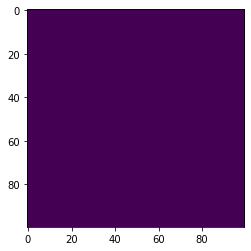

In [68]:
fit_history[-1]

array([ -5.59101055,   1.82798947,   1.54396848,   1.89074448,
        -5.47791982, -13.60370885,  -4.51103202,  10.7140463 ,
         2.72100865,  14.55350541,   2.26159905,  -6.32349972,
        -6.24592477,  -2.38124418])

In [58]:
fit_history.shape

(100, 14)

In [61]:
q=np.vectorize(model_loss_function_pure)(fit_history)

In [62]:
q.shape

(100, 14)

In [63]:
fit_history

array([[ 1.6       ,  0.15      , -0.04      , ..., -0.1       ,
         0.4       ,  0.15      ],
       [-5.21316887,  1.56564855,  1.78857258, ...,  0.21211834,
        -3.64593418,  4.2487072 ],
       [-5.21902999,  1.55632958,  1.79673005, ...,  0.27291455,
        -3.46120529,  4.2446362 ],
       ...,
       [-5.59101055,  1.82798947,  1.54396848, ..., -6.32349972,
        -6.24592477, -2.38124418],
       [-5.59101055,  1.82798947,  1.54396848, ..., -6.32349972,
        -6.24592477, -2.38124418],
       [-5.59101055,  1.82798947,  1.54396848, ..., -6.32349972,
        -6.24592477, -2.38124418]])